# 10.  Use transfer learning for large image classification

_Exercise: Use transfer learning for large image classification, going through these steps:_

* _Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets)._
* _Split it into a training set, a validation set, and a test set._
* _Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation._
* _Fine-tune a pretrained model on this dataset._

In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1741005225.782857    1015 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [4]:
import tensorflow_datasets as tfds

from keras.api.layers import Conv2D, MaxPooling2D, InputLayer, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from keras.api.models import Sequential, Model
# from keras.api.applications.xception import Xception, preprocess_input
from keras.api.applications.mobilenet import MobileNet, preprocess_input
from keras.api.optimizers import SGD, Nadam, Adam
from keras.api.optimizers.schedules import CosineDecayRestarts
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.api import layers
from keras.api.regularizers import l2
import keras

import collections

import numpy as np

import matplotlib.pyplot as plt

import datetime

from sklearn.model_selection import train_test_split

In [5]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

## Loading data

In [6]:
# ds, info = tfds.load(
#     "beans",
#     split=["train", "validation", "test"],
#     with_info=True,
#     shuffle_files=True,
#     as_supervised=True,
# )

# ds_train = ds[0]
# ds_valid = ds[1]
# ds_test = ds[2]

ds, info = tfds.load(
    "beans",
    split="all",
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
)

n_classes = info.features["label"].num_classes
class_names = info.features["label"].names

# Same ratio as in original dataset
train_size = 1034
val_size = 133
test_size = 128

batch_size = 32

In [7]:
ds_pd = tfds.as_dataframe(ds, info)
ds_pd_images = ds_pd["image"]
ds_pd_labels = ds_pd["label"]

2025-03-03 13:33:47.292989: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-03 13:33:48.175582: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
ds_pd_images.shape

(1295,)

In [9]:
ds_pd_labels.shape

(1295,)

In [10]:
train_data, temp_data, train_labels, temp_labels = train_test_split(
    ds_pd_images,
    ds_pd_labels,
    train_size=train_size,
    random_state=42,
    shuffle=True,
    stratify=ds_pd_labels,
)

val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data,
    temp_labels,
    train_size=val_size,
    random_state=42,
    shuffle=True,
    stratify=temp_labels,
)

ds_train = tf.data.Dataset.from_tensor_slices((np.array(train_data.tolist()), np.array(train_labels.tolist())))
ds_valid = tf.data.Dataset.from_tensor_slices((np.array(val_data.tolist()), np.array(val_labels.tolist())))
ds_test = tf.data.Dataset.from_tensor_slices((np.array(test_data.tolist()), np.array(test_labels.tolist())))

In [11]:
print(len(list(ds_train)))
print(len(list(ds_valid)))
print(len(list(ds_test)))

1034
133
128


2025-03-03 13:33:50.802720: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-03 13:33:50.934393: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
info.description

'Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class.\nDiseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by\nexperts from the National Crops Resources Research Institute (NaCRRI) in Uganda\nand collected by the Makerere AI research lab.'

In [13]:
ds_train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
for image, label in ds_train.take(2):
  print(image.shape, label)

(500, 500, 3) tf.Tensor(2, shape=(), dtype=int64)
(500, 500, 3) tf.Tensor(0, shape=(), dtype=int64)


In [15]:
def count_labels(dataset):
    label_counts = collections.Counter()

    for _, label in dataset:
        label_counts[label.numpy()] += 1

    total_count = sum(label_counts.values())
    label_ratios = {label: count / total_count for label, count in label_counts.items()}
    
    sorted_label_ratios = dict(sorted(label_ratios.items()))

    return sorted_label_ratios

In [16]:
# Make sure that ratio of different classes is same across datasets

print(count_labels(ds_train))
print(count_labels(ds_valid))
print(count_labels(ds_test))

{0: 0.33365570599613154, 1: 0.3365570599613153, 2: 0.32978723404255317}
{0: 0.3308270676691729, 1: 0.3383458646616541, 2: 0.3308270676691729}
{0: 0.3359375, 1: 0.3359375, 2: 0.328125}


2025-03-03 13:33:51.395479: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Preprocess and Augmentation

In [ ]:
# preprocess = Sequential([
#     layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
#     layers.Lambda(preprocess_input)
# ])

preprocess_and_augmentation = Sequential([
    layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(factor=(-0.2, 0.2)),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    # layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)), 
    layers.RandomContrast(factor=0.2),
    layers.RandomBrightness(factor=(-0.2, 0.2)),
    layers.GaussianNoise(stddev=0.05),
    layers.Lambda(preprocess_input)
])

## Input pipeline

In [18]:
# ds_train = ds_train.map(
#     lambda X, y: (preprocess_and_augmentation(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [19]:
# ds_valid = ds_valid.map(
#     lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.batch(batch_size)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [20]:
# ds_test = ds_test.map(
#     lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

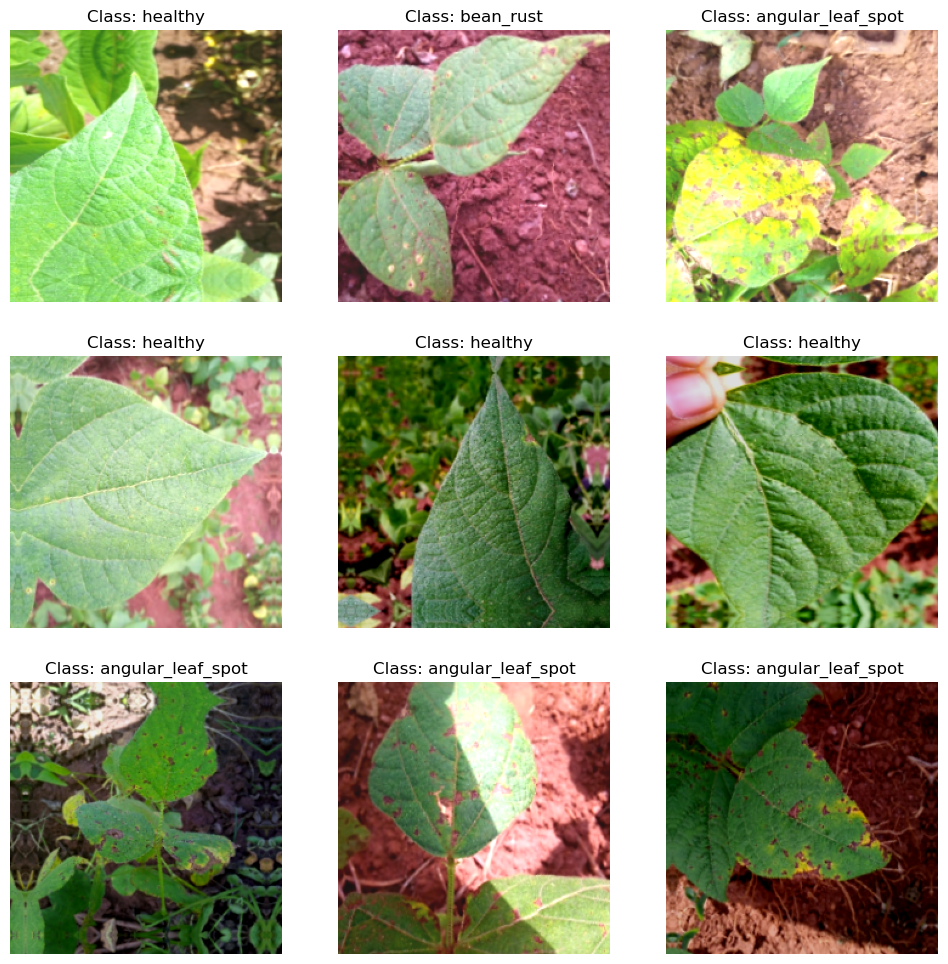

In [44]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in ds_train.take(1):
    X_batch = preprocess_and_augmentation(X_batch)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

## Base model with pre-trained weights

In [22]:
tf.keras.backend.clear_session()

In [23]:
# TODO: Test if we can drop dropout - increasing it didn't have any effect
base_model = MobileNet(
    input_shape=(224, 224, 3), weights="imagenet", include_top=False, dropout=0.1
)

# Freeze the convolutional base
base_model.trainable = False

base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [24]:
inputs = Input(shape=(500, 500, 3))
x = preprocess_and_augmentation(inputs)
x = base_model(x, training=False)
# inputs = Input(shape=(224, 224, 3))
# x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
outputs = Dense(n_classes, activation="softmax", kernel_regularizer=l2(0.01))(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 500, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,236,035 (12.34 MB)

 Trainable params: 5,123 (20.01 KB)

 Non-trainable params: 3,230,912 (12.32 MB)

In [25]:
# This is only needed when we use base_model layers directly (base_model.output)
#
# for layer in base_model.layers:
#     layer.trainable = False

In [26]:
initial_learning_rate = 0.001  # Slightly increased learning rate
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=10,  # Adjusted steps
    t_mul=2.0,
    m_mul=0.9,
    alpha=0.0001,  # Adjusted minimum lr
)

In [27]:
def one_cycle_scheduler(epoch, lr):
    max_lr = 0.0005 # Reduced max learning rate
    epochs = 100
    if epoch < epochs * 0.4:
        return max_lr * epoch / (epochs * 0.4)
    else:
        return max_lr * (1 + np.cos(np.pi * (epoch - epochs * 0.4) / (epochs * 0.6))) / 2

lr_callback = LearningRateScheduler(one_cycle_scheduler)

In [28]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode="min")
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

## Initial training without touching base model

In [29]:
optimizer = Nadam(learning_rate=1e-4)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    callbacks=[early_stopping, lr_callback],
)

Epoch 1/100


I0000 00:00:1741005238.223520    2605 cuda_dnn.cc:529] Loaded cuDNN version 90700


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.3364 - loss: 2.1501 - val_accuracy: 0.3158 - val_loss: 1.6268 - learning_rate: 0.0000e+00
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.3744 - loss: 2.0701 - val_accuracy: 0.3083 - val_loss: 1.5552 - learning_rate: 1.2500e-05
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.3918 - loss: 1.9590 - val_accuracy: 0.3534 - val_loss: 1.4859 - learning_rate: 2.5000e-05
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - accuracy: 0.3933 - loss: 1.9932 - val_accuracy: 0.3835 - val_loss: 1.4081 - learning_rate: 3.7500e-05
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.4331 - loss: 1.7538 - val_accuracy: 0.4060 - val_loss: 1.3324 - learning_rate: 5.0000e-05
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.4214 - loss: 1.7439 - val_accuracy: 0.4662 - val_loss: 1.2427 - learning_rate: 6.2500e-05
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.47

In [30]:
early_stopping.best_epoch

91

4/4 - 1s - 222ms/step - accuracy: 0.9141 - loss: 0.3005
0.9140625


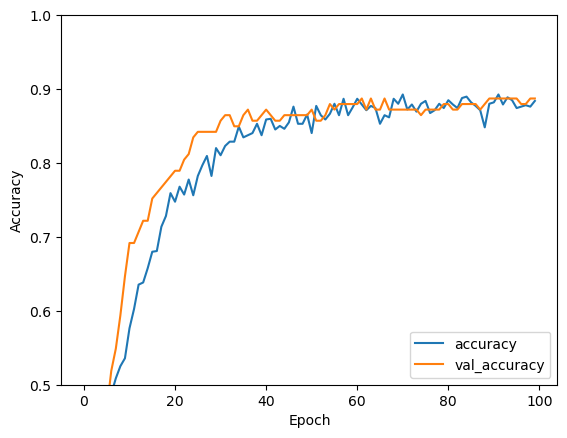

In [31]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

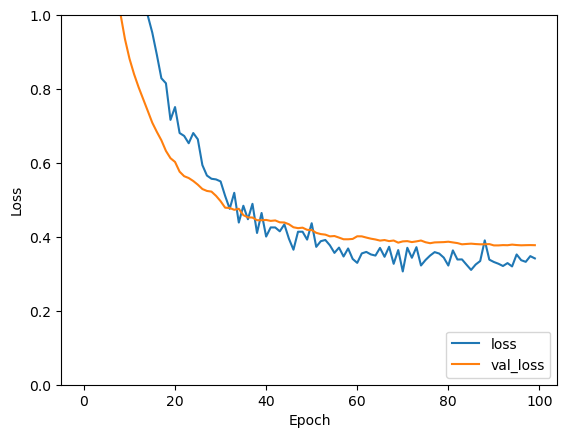

In [32]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## Fine tuning

In [33]:
len(base_model.layers)

86

In [34]:
# Callbacks (repeating here because EarlyStopping stopped too early second time - better restart it)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode="min")
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [35]:
# TensorBoard Callback (repeating here to have unique timestamp)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [36]:
# Fine tuning learning rate scheduler
def fine_tune_lr_scheduler(epoch, lr):
    initial_lr = 1e-5
    decay_rate = 0.95
    return initial_lr * (decay_rate ** epoch)

fine_tune_lr_callback = LearningRateScheduler(fine_tune_lr_scheduler)

In [37]:
base_model.trainable = True

# for layer in base_model.layers[-42:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True  # Unfreeze the top layers while leaving BatchNorm layers frozen.

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-42]:
  layer.trainable = False

optimizer = Nadam(learning_rate=1e-5)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    callbacks=[early_stopping, tensorboard_callback, fine_tune_lr_callback],
)

Epoch 1/100


33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 586ms/step - accuracy: 0.8331 - loss: 0.4881 - val_accuracy: 0.8947 - val_loss: 0.4116 - learning_rate: 1.0000e-05
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 497ms/step - accuracy: 0.8531 - loss: 0.3963 - val_accuracy: 0.8947 - val_loss: 0.4367 - learning_rate: 9.5000e-06
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 0.8003 - loss: 0.4797 - val_accuracy: 0.8722 - val_loss: 0.4622 - learning_rate: 9.0250e-06
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.8473 - loss: 0.4058 - val_accuracy: 0.8647 - val_loss: 0.4910 - learning_rate: 8.5738e-06
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 0.8554 - loss: 0.4020 - val_accuracy: 0.8346 - val_loss: 0.5161 - learning_rate: 8.1451e-06
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 479ms/step - accuracy: 0.8581 - loss: 0.4010 - val_accuracy: 0.8346 - val_loss: 0.4997 - learning_rate: 7.7378e-06
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - accuracy

In [38]:
early_stopping.best_epoch

96

In [39]:
val_loss, val_acc = model.evaluate(ds_valid, verbose=2)
print(val_acc)

5/5 - 1s - 183ms/step - accuracy: 0.8872 - loss: 0.3525
0.8872180581092834


In [40]:
train_loss, train_acc = model.evaluate(ds_train, verbose=2)
print(train_acc)

33/33 - 7s - 212ms/step - accuracy: 0.9458 - loss: 0.1615
0.945841372013092


4/4 - 1s - 221ms/step - accuracy: 0.9141 - loss: 0.2276
0.9140625


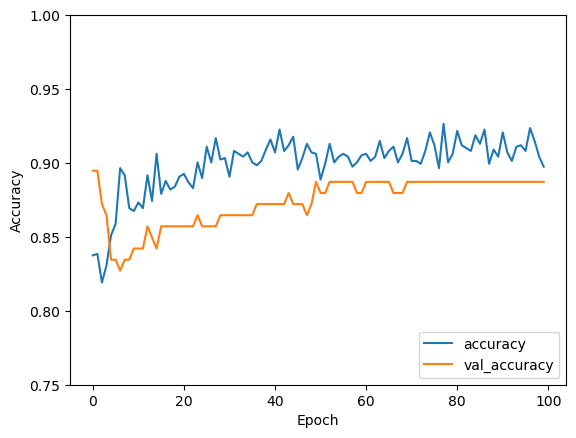

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

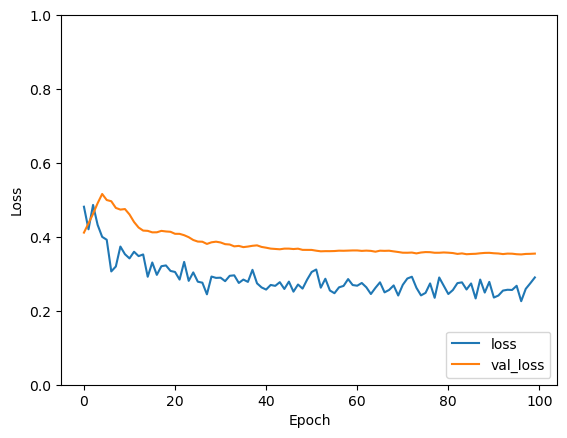

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

- accuracy without data augmentation or dropout: train: 1.00, validation: 0.9323, test: 0.9062
- accuracy with data augmentation but without dropout: train: 1.00, validation: 0.9549, test: 0.9062
- accuracy with data augmentation and dropout (0.25) : train: 0.9993, validation: 0.9549, test: 0.9453 